## Building Chains

In [109]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

In [110]:
messages = [AIMessage(content="Hello, How can I help you today !", name="LLM")]

messages.extend([HumanMessage(content="I am fine, Thank You.", name="Human")])
messages.extend([AIMessage(content="Great !, I am fine too. How can I help you today ?", name="LLM")])
messages.extend([HumanMessage(content="Great !, all is fine on my end.", name="Human")])


In [111]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hello, How can I help you today !
================================ Human Message =================================
Name: Human

I am fine, Thank You.
================================== Ai Message ==================================
Name: LLM

Great !, I am fine too. How can I help you today ?
================================ Human Message =================================
Name: Human

Great !, all is fine on my end.


### Chat Models

In [112]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

In [113]:
%reload_ext dotenv
%dotenv

In [114]:
model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))

In [115]:
results = model.invoke(messages)

In [116]:
print("Result")
print("================================================")
print(results.response_metadata)
print("================================================")
print(results.content)

Result
{'token_usage': {'completion_tokens': 26, 'prompt_tokens': 70, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'stop', 'logprobs': None}
That's good to hear! If there's anything specific you'd like to talk about or any questions you have, feel free to ask.


In [117]:
def addition(a: int, b: int) -> int:
    """Use this tool for adding two numbers"""
    return a+b

In [118]:
llm_with_tool = model.bind_tools([addition])

In [119]:
llm_with_tool_response = llm_with_tool.invoke([HumanMessage(content="What is the sum of 10 and 20", name="Rutvik")])

In [120]:
print("Result")
print("================================================")
print(llm_with_tool_response)

Result
content='' additional_kwargs={'tool_calls': [{'id': 'call_QljHEApXeeBTNpPDbcDUX2op', 'function': {'arguments': '{"a":10,"b":20}', 'name': 'addition'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 61, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-049c11e0-1135-4c2e-bf77-658301d75de5-0' tool_calls=[{'name': 'addition', 'args': {'a': 10, 'b': 20}, 'id': 'call_QljHEApXeeBTNpPDbcDUX2op', 'type': 'tool_call'}] usage_metadata={'input_tokens': 61, 'output_tokens': 19, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


### Using Messages As State

In [121]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import TypedDict, List, Annotated

In [122]:
class MessageState(TypedDict):
    message: Annotated[List[AnyMessage], add_messages]



In [123]:
messages = [
    HumanMessage(content="Hello, how are you doing.", name="Rutvik"),
    AIMessage(content="Hello Rutvik, I am Fine Thank you.", name="LLM")
]

In [124]:
additional_msg = [HumanMessage(content="I am fine too. How is work on your end.", name="Rutvik")]

for message in messages:
    message.pretty_print()

================================ Human Message =================================
Name: Rutvik

Hello, how are you doing.
================================== Ai Message ==================================
Name: LLM

Hello Rutvik, I am Fine Thank you.


In [125]:
updated_messages = add_messages(messages, additional_msg)

In [126]:
for message in updated_messages:
    message.pretty_print()

================================ Human Message =================================
Name: Rutvik

Hello, how are you doing.
================================== Ai Message ==================================
Name: LLM

Hello Rutvik, I am Fine Thank you.
================================ Human Message =================================
Name: Rutvik

I am fine too. How is work on your end.


### Putting it all together

In [140]:
def sample(state: MessageState) -> MessageState:
    model = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
    llm_with_tool = model.bind_tools([addition])
    llm_with_tool_response = llm_with_tool.invoke(state["messages"])
    return {"messages": [llm_with_tool_response]}

### Building Agent Graph

In [141]:
from langgraph.graph import MessagesState, START, END, StateGraph

In [142]:
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", sample)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

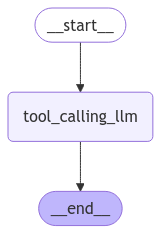

In [143]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### Invocation

In [144]:
result = graph.invoke({"messages": HumanMessage(content="What is the sum of 10 and 30", name="Rutvik")})

KeyError: 'messages'